In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import sem

mpl.rcParams.update({'font.size': 9})
mpl.rcParams.update({'font.family': 'Arial'})

FONT_BG = 9

mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

np.set_printoptions(precision=10, suppress=True)

*Load the data*

In [2]:
d = np.load('./data/pfeiffer/GR.npz', allow_pickle=True)

posto = d['posto']
pret = d['pretrial_replays']
ttypes = d['trial_types']
home_wells = d['home_wells']
sampled_goals = d['sampled_goals']

ddh = d['ddh'] # Home
ddnh = d['ddnh'] # Not home

num_mice = posto.shape[0]
num_sessions = posto.shape[1]
num_trials = posto.shape[2]
num_replay_steps = posto.shape[3]
goal_states = list(d['goal_states'])

# Collate the sampled goals list
concat_sampled_goals = np.zeros((num_mice, num_sessions * num_trials))
for mdx in range(num_mice):
    for sdx in range(num_sessions):
        concat_sampled_goals[mdx, sdx * num_trials : (sdx + 1) * num_trials] = sampled_goals[mdx, sdx, :]

*Figure 5B: Fraction of replays containing the goal, split by category*

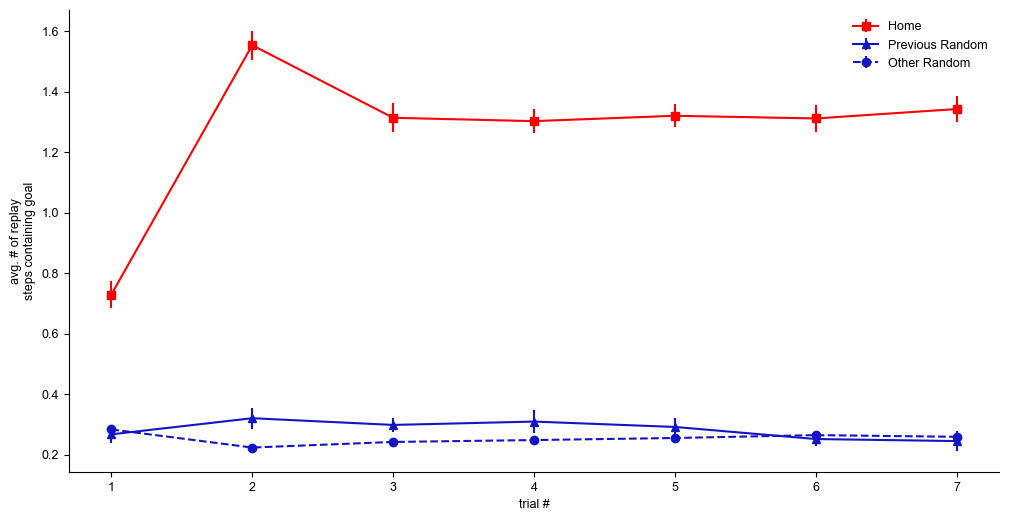

In [3]:
# Fraction of replays containing the goal, split by category of goal (Home, Previous Random, Other)
avg_both_t0 = False  # Average pre- and post-trial replays on the very first trial
combine_homerandom = True  # Merge each Home-Random trial pair into one big trial (following Pfeiffer's convention)

NUM_CATS = 3 # Home, Previous Random, Other Random
agg_rep_cnts = np.zeros((num_mice, num_sessions - 1, NUM_CATS, num_trials))
for mdx in range(num_mice):
    prev_random = None
    
    for sdx in range(1, num_sessions):
        home = int(home_wells[mdx, sdx])
        home_idx = goal_states.index(home)
        session_ttypes = ttypes[mdx, sdx, :]
        
        for trial in range(num_trials):
            if session_ttypes[trial] == 1: # Random trial
                concat_idx = sdx * num_trials + trial
                prev_random = concat_sampled_goals[mdx, concat_idx - 2]
                prev_random_idx = goal_states.index(prev_random)
                
            # Get the trial replay
            if trial == 0:
                if avg_both_t0:
                    trial_replay = np.vstack((pret[mdx, sdx], posto[mdx, sdx, trial]))
                else:
                    trial_replay = pret[mdx, sdx]
            else:
                trial_replay = posto[mdx, sdx, trial]
                
            trial_replay = trial_replay[:, 2]
                
            # Categorize
            for replay_state in trial_replay.flatten():
                div = 1
                if avg_both_t0:
                    if trial == 0:
                        div = 2

                if replay_state == home:
                    agg_rep_cnts[mdx, sdx - 1, 0, trial] += 1 / div
                elif replay_state == prev_random:
                    agg_rep_cnts[mdx, sdx - 1, 1, trial] += 1 / div
                elif replay_state in goal_states:
                    agg_rep_cnts[mdx, sdx - 1, 2, trial] += 1 / ((len(goal_states) - 2) * div)

# Combine Home and Random trials
agg_rep_cnts_cmb = np.zeros((num_mice, num_sessions - 1, NUM_CATS, int(num_trials / 2)))
for mdx in range(num_mice):
    for sdx in range(1, num_sessions):
        for trial in range(int(num_trials / 2)):
            agg_rep_cnts_cmb[mdx, sdx - 1, :, trial] = agg_rep_cnts[mdx, sdx - 1, :, 2*trial] + agg_rep_cnts[mdx, sdx - 1, :, 2*trial + 1]
            agg_rep_cnts_cmb[mdx, sdx - 1, :, trial] /= 2  # Average

# Normalization
if combine_homerandom:
    sess_mean_agg_rep_cnts = np.mean(agg_rep_cnts_cmb, axis=1)
    mean_agg_rep_cnts = np.mean(sess_mean_agg_rep_cnts, axis=0)

    sem_agg_rep_cnts = sem(sess_mean_agg_rep_cnts, axis=0)
else:
    sess_mean_agg_rep_cnts = np.mean(agg_rep_cnts, axis=1)
    mean_agg_rep_cnts = np.mean(sess_mean_agg_rep_cnts, axis=0)

    sem_agg_rep_cnts = sem(sess_mean_agg_rep_cnts, axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.errorbar(np.arange(1, len(mean_agg_rep_cnts[0, :]) + 1), mean_agg_rep_cnts[0, :], yerr=sem_agg_rep_cnts[0, :], label='Home', marker='s', color='r')
plt.errorbar(np.arange(1, len(mean_agg_rep_cnts[1, :]) + 1), mean_agg_rep_cnts[1, :], yerr=sem_agg_rep_cnts[1, :], label='Previous Random', marker='^', color='#1414c4')
plt.errorbar(np.arange(1, len(mean_agg_rep_cnts[2, :]) + 1), mean_agg_rep_cnts[2, :], yerr=sem_agg_rep_cnts[2, :], label='Other Random', marker='o', linestyle='--', color='#1414c4')
plt.ylabel('avg. # of replay\nsteps containing goal')
plt.xlabel('trial #')
plt.legend(frameon=False)
plt.savefig('./fig5B_replay_decomposition.pdf', transparent=True)


*Figure 5C: Expected navigation improvement after home-containing vs. home non-containing replays*

Text(0, 0.5, 'Expected improvement')

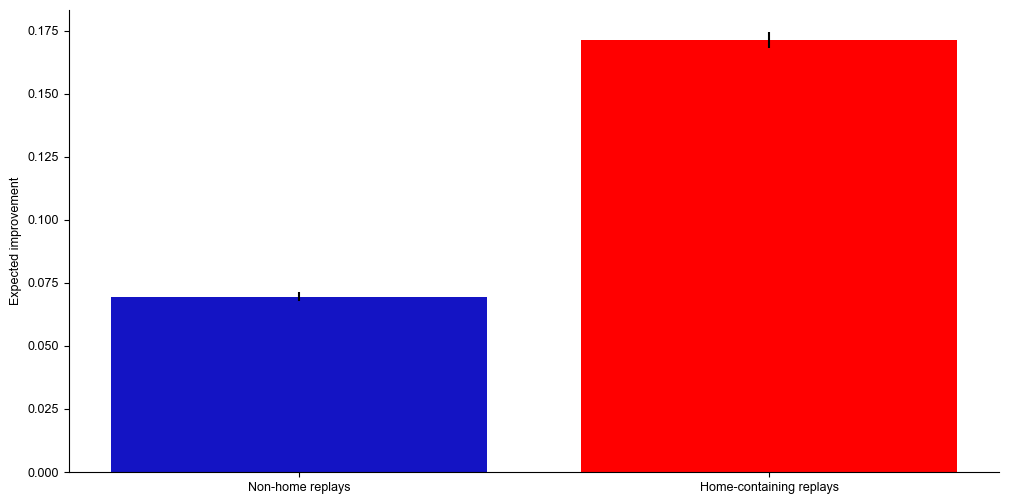

In [4]:
# Check difference in distance to goal before vs. after replay
mean_ddh = np.nanmean(ddh)
sem_ddh = sem(ddh.flatten(), nan_policy='omit')

mean_ddnh = np.nanmean(ddnh)
sem_ddnh = sem(ddnh.flatten(), nan_policy='omit')

plt.figure(figsize=(12, 6))
plt.bar(1, mean_ddnh, yerr=sem_ddnh, color='#1414c4')
plt.bar(2, mean_ddh, yerr=sem_ddh, color='r')
plt.xticks([1, 2], ['Non-home replays', 'Home-containing replays'])
plt.ylabel('Expected improvement')
plt.savefig('./fig6B_expected_improvement.pdf', transparent=True)